In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Verify that there ar not complex numbers and that the matrix is symmetrical

In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

0

### Visualization of the covariance matrix:

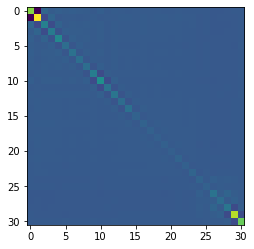

In [4]:
plt.imshow(syscov)

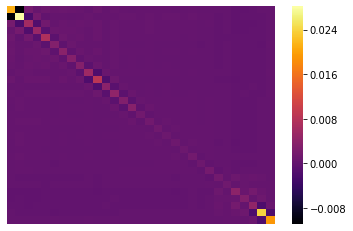

In [5]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')
plt.savefig("original_cov_binned_JLA.png", dpi=200)

In [6]:
np.min(np.abs(syscov)), np.max(np.abs(syscov)) #checking non-negatives in the diagonal

(1.695011341e-07, 0.02815552265)

### Generate a data set with covariance matrix from the original plus gaussian noise

In [7]:
numMatrix = 1000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal() 
#     val, vec = np.linalg.eigh(syscov)
#     D = np.diag(val)    
#     covset[i] = (vec+0.0001*err) @ (D) @ (vec+0.0001*err).T
    err = np.random.normal(size=syscov.shape) 
    covset[i] = syscov + 0.001 * err
    covset_noise[i] = syscov + 0.05 * err
#     covset_noise[i] = syscov + 0.001*err

 Generating 1000 matrix 

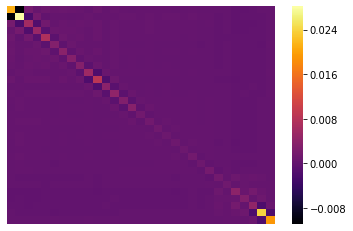

In [8]:
val, vec = np.linalg.eigh(syscov)
D = np.diag(val)
new = (vec+0.1) @ (D) @ (vec+0.1).T
sns.heatmap(pd.DataFrame(syscov), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

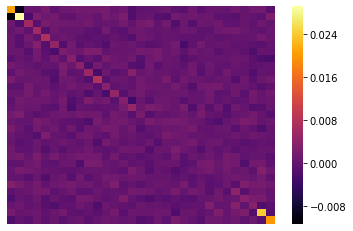

In [9]:
sns.heatmap(pd.DataFrame(covset[10]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

In [10]:
print(np.shape(covset))

(1000, 31, 31)


(1000, 31, 31)


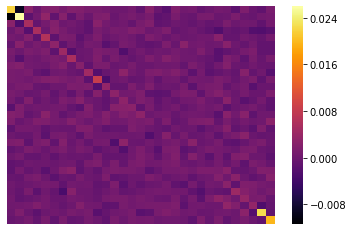

In [11]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))



In [12]:
# input_cov = Input(shape=(31, 31, 1))

# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img = tf.keras.Input(shape=(31*31,))
# begin encoder
x = layers.Dense(100, activation='tanh')(input_img)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
encoded = layers.Dense(encoding_dim, activation='tanh')(x)
x = layers.Dropout(0.2)(encoded)
#begin decoder
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
decoded = layers.Dense(31*31, activation='linear')(x)


# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               96200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                3131      
_________________________________________________________________
dropout_2 (Dropout)          (None, 31)               

In [13]:
encoder = tf.keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))

decoder_layer1 = autoencoder.layers[-5]
decoder_layer2 = autoencoder.layers[-4]
decoder_layer3 = autoencoder.layers[-3]
decoder_layer4 = autoencoder.layers[-2]
decoder_layer5 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, 
                decoder_layer5(decoder_layer4(decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))))

In [14]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=10, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=500,
                batch_size=32,
                shuffle=True,
                validation_data=(covset_noise_test, covset_test),
                callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/500
25/25 [==============================] - 0s 6ms/step - loss: 8.9155e-04 - val_loss: 6.9772e-05
Epoch 2/500
25/25 [==============================] - 0s 3ms/step - loss: 1.9812e-04 - val_loss: 2.0179e-05
Epoch 3/500
25/25 [==============================] - 0s 2ms/step - loss: 9.9268e-05 - val_loss: 1.0468e-05
Epoch 4/500
25/25 [==============================] - 0s 2ms/step - loss: 6.6954e-05 - val_loss: 6.8459e-06
Epoch 5/500
25/25 [==============================] - 0s 2ms/step - loss: 4.8394e-05 - val_loss: 4.8486e-06
Epoch 6/500
25/25 [==============================] - 0s 2ms/step - loss: 3.7739e-05 - val_loss: 3.7963e-06
Epoch 7/500
25/25 [==============================] - 0s 2ms/step - loss: 3.1219e-05 - val_loss: 3.0368e-06
Epoch 8/500
25/25 [==============================] - 0s 2ms/step - loss: 2.5928e-05 - val_loss: 2.5816e-06
Epoch 9/500
25/25 [==============================] - 0s 2ms/step - loss: 2.1291e-05 - val_loss: 2.1740e-06
Epoch 10/500
25/25 [=================

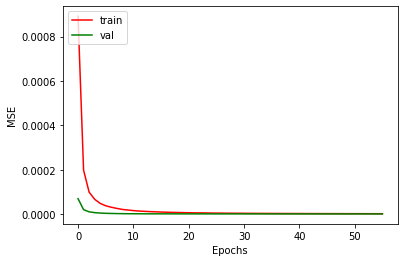

In [15]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLA.png', dpi=200)

In [16]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

1.0444260851727451e-06 1.968961896636756e-06


In [17]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
# np.min(encoded_imgs)

(200, 31)


(200, 961)


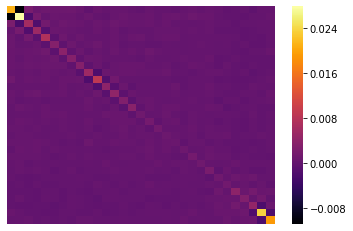

In [18]:
print(np.shape(decoded_imgs))

sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")
# this cov matrix work well within Bayesian inference
# np.savetxt("test.dat", decoded_imgs[0].reshape(31,31), delimiter= " ", header="#fake COV")


In [19]:
print(np.shape(decoded_imgs))

(200, 961)


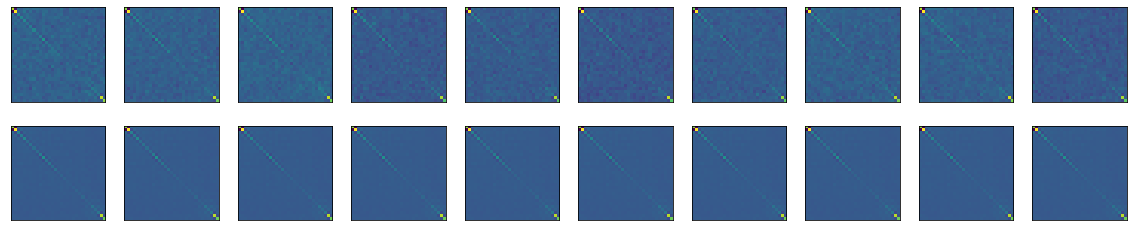

In [20]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(covset_test[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

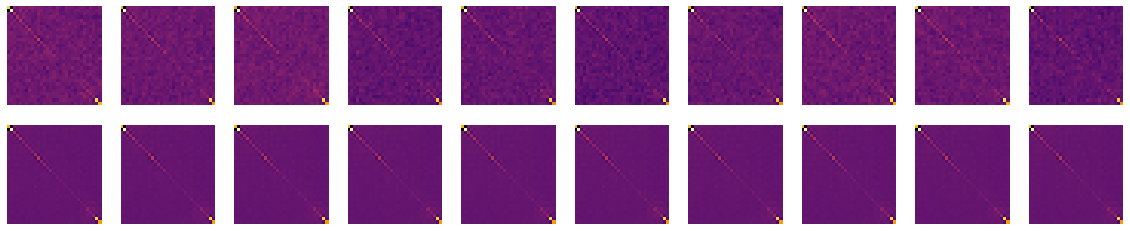

In [21]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
plt.savefig('predicted_covs_binned_jla.png', dpi=200)

### Now we train another neural network for z and $D_L(z)$

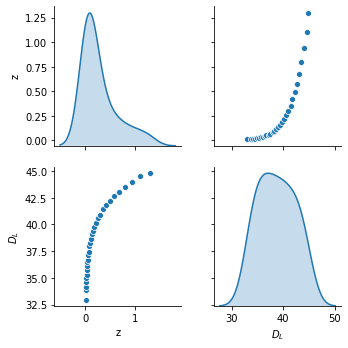

In [22]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
# print(data.head(31))
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistbinnedJLA.png")

In [23]:
shuffle = [x for x in range(len(data.values)) if x%2 == 0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)

data = data.values[shuffle]

In [24]:
z = data[:,0]
dl = data[:,1:]

In [25]:
# scalerz = StandardScaler()
# # scalerz = MinMaxScaler(feature_range=(-1,1))
# # fit scaler on data
# scalerz.fit(z.reshape(-1,1))
# # apply transform
# z = scalerz.transform(z.reshape(-1,1))

In [26]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1, 1))
zz = scalerz.transform(z.reshape((-1,1)))
z_train, z_test = np.split(zz, indx)
dl_train, dl_test = np.split(dl, indx)

In [27]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=20,
                                   restore_best_weights=True)]

In [28]:
def model(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(50, activation='relu')(efirst)
    x = Dense(50, activation='relu')(x)
    x = Dense(30, activation='relu')(x)

    elast = Dense(1, activation='linear')(x)
    return elast

batch_size = 1
epochs = 300
input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 31        
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
____________________________________________________

In [29]:
model_train = neural_model.fit(z_train, dl_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, dl_test))
#                                     callbacks=callbacks)

Epoch 1/300
24/24 [==============================] - 0s 4ms/step - loss: 1421.5358 - val_loss: 1702.0021
Epoch 2/300
24/24 [==============================] - 0s 1ms/step - loss: 1329.6808 - val_loss: 1563.7614
Epoch 3/300
24/24 [==============================] - 0s 1ms/step - loss: 1032.7965 - val_loss: 1115.6801
Epoch 4/300
24/24 [==============================] - 0s 1ms/step - loss: 375.9734 - val_loss: 299.6717
Epoch 5/300
24/24 [==============================] - 0s 993us/step - loss: 102.3709 - val_loss: 187.1661
Epoch 6/300
24/24 [==============================] - 0s 1ms/step - loss: 87.1481 - val_loss: 194.3149
Epoch 7/300
24/24 [==============================] - 0s 1ms/step - loss: 70.7094 - val_loss: 130.4347
Epoch 8/300
24/24 [==============================] - 0s 1ms/step - loss: 70.1900 - val_loss: 142.5061
Epoch 9/300
24/24 [==============================] - 0s 1ms/step - loss: 58.9873 - val_loss: 123.4938
Epoch 10/300
24/24 [==============================] - 0s 1ms/step - l

24/24 [==============================] - 0s 969us/step - loss: 0.7820 - val_loss: 0.4859
Epoch 83/300
24/24 [==============================] - 0s 1ms/step - loss: 0.8813 - val_loss: 0.3500
Epoch 84/300
24/24 [==============================] - 0s 1ms/step - loss: 1.0403 - val_loss: 0.4401
Epoch 85/300
24/24 [==============================] - 0s 1ms/step - loss: 0.6996 - val_loss: 0.2113
Epoch 86/300
24/24 [==============================] - 0s 1ms/step - loss: 0.6553 - val_loss: 0.2972
Epoch 87/300
24/24 [==============================] - 0s 1ms/step - loss: 0.9828 - val_loss: 0.4889
Epoch 88/300
24/24 [==============================] - 0s 1ms/step - loss: 0.9899 - val_loss: 0.7367
Epoch 89/300
24/24 [==============================] - 0s 1ms/step - loss: 0.8056 - val_loss: 1.4688
Epoch 90/300
24/24 [==============================] - 0s 1ms/step - loss: 1.0769 - val_loss: 0.9446
Epoch 91/300
24/24 [==============================] - 0s 1ms/step - loss: 1.0855 - val_loss: 2.7612
Epoch 92/30

24/24 [==============================] - 0s 1ms/step - loss: 0.7139 - val_loss: 1.1209
Epoch 164/300
24/24 [==============================] - 0s 1ms/step - loss: 0.5267 - val_loss: 0.2565
Epoch 165/300
24/24 [==============================] - 0s 1ms/step - loss: 0.6293 - val_loss: 1.1205
Epoch 166/300
24/24 [==============================] - 0s 1ms/step - loss: 0.6213 - val_loss: 0.5298
Epoch 167/300
24/24 [==============================] - 0s 1ms/step - loss: 0.3187 - val_loss: 1.2897
Epoch 168/300
24/24 [==============================] - 0s 1ms/step - loss: 0.5073 - val_loss: 0.1124
Epoch 169/300
24/24 [==============================] - 0s 1ms/step - loss: 0.4929 - val_loss: 0.7283
Epoch 170/300
24/24 [==============================] - 0s 1ms/step - loss: 0.4828 - val_loss: 0.2453
Epoch 171/300
24/24 [==============================] - 0s 1ms/step - loss: 0.5971 - val_loss: 0.2834
Epoch 172/300
24/24 [==============================] - 0s 1ms/step - loss: 0.3665 - val_loss: 0.1398
Epoc

24/24 [==============================] - 0s 1ms/step - loss: 0.3785 - val_loss: 0.1442
Epoch 245/300
24/24 [==============================] - 0s 1ms/step - loss: 0.5377 - val_loss: 0.6711
Epoch 246/300
24/24 [==============================] - 0s 1ms/step - loss: 0.5008 - val_loss: 0.1090
Epoch 247/300
24/24 [==============================] - 0s 1ms/step - loss: 0.4717 - val_loss: 0.0511
Epoch 248/300
24/24 [==============================] - 0s 1ms/step - loss: 0.5255 - val_loss: 2.6969
Epoch 249/300
24/24 [==============================] - 0s 1ms/step - loss: 1.1751 - val_loss: 0.2318
Epoch 250/300
24/24 [==============================] - 0s 1ms/step - loss: 0.3116 - val_loss: 0.0904
Epoch 251/300
24/24 [==============================] - 0s 1ms/step - loss: 0.4227 - val_loss: 0.1059
Epoch 252/300
24/24 [==============================] - 0s 1ms/step - loss: 0.3448 - val_loss: 0.2724
Epoch 253/300
24/24 [==============================] - 0s 1ms/step - loss: 0.6233 - val_loss: 1.4906
Epoc

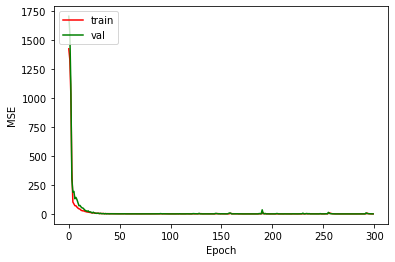

In [30]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_dlbinnedJla.png", dpi=200)

In [31]:
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet, np.min(model_train.history['loss']), np.min(model_train.history['val_loss'])

(0.1915687338482144, 0.1941102147102356, 0.03669857978820801)

In [32]:
# pred = neural_model.predict(z_test)
# pred

In [33]:
# ranz = np.random.uniform(np.min(z), np.max(z), size=31)
ranz = np.linspace(np.min(z), np.max(z), 31)
ranzz = scalerz.transform(ranz.reshape((-1,1)))

# ranzinv = scalerz.transform(ranz.reshape(-1,1))

pred_random = neural_model.predict(ranzz)
# pred_random

In [34]:
# recover z
# z = scalerz.inverse_transform(z)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$



In [35]:
fake_encoded = np.zeros((1, 31))

In [36]:
print(np.shape(fake_encoded))
avg_encoded = np.mean(encoded_imgs, axis=0)
print(np.shape(avg_encoded))
print(np.shape(encoded_imgs))


(1, 31)
(31,)
(200, 31)


In [37]:
for i, avg in enumerate(avg_encoded):
    alpha = avg/zz[i]
    fake_encoded[0, i] = alpha * ranzz[i]

In [38]:
decoded_fake = decoder.predict(fake_encoded)
np.shape(decoded_fake), np.shape(fake_encoded)

((1, 961), (1, 31))

In [39]:
# decoded_fake[0, :]

1.9012841e-06

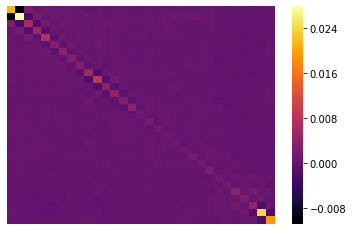

In [40]:
sns.heatmap(pd.DataFrame(decoded_fake[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
plt.savefig('fake_cov_jla.png', dpi=200)
np.min(np.abs(decoded_fake[0, :]))

-0.01084098704 0.02815552265 0.00039265133851975654
-0.010804033 0.027840331 0.0003963376
-0.01083363 0.027884003 0.00039721027


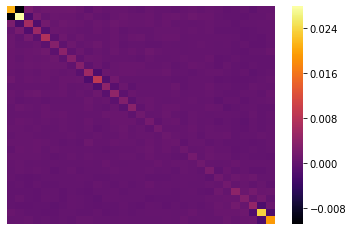

In [41]:
clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
sns.heatmap(pd.DataFrame(clean_img[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.savefig('fake_cov_clean_jla.png', dpi=200)
np.min(np.abs(clean_img[0, :]))

print(np.min(syscov), np.max(syscov), np.mean(syscov)) #checking non-negatives in the diagonal
print(np.min(decoded_fake[0,:]), np.max(decoded_fake[0,:]), np.mean(decoded_fake[0,:])) #checking non-negatives in the diagonal
print(np.min(clean_img[0,:]), np.max(clean_img[0,:]), np.mean(clean_img[0,:])) #checking non-negatives in the diagonal



In [42]:
np.savetxt("fake_binned_JLA_COVdecoded.dat", decoded_fake[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
np.savetxt("fake_binned_JLA_COVdecodedclean.dat", clean_img[0, :].reshape(31,31), delimiter= " ", header="#fake COV")

In [43]:
count = 0
new_cov =decoded_fake[0, :].reshape(31,31)

for i in range(len(new_cov)):
    for j in range(len(new_cov)):
        if np.iscomplex(new_cov[i,j]):
            print("COMPLEX")
        if new_cov[i,j] != new_cov[j,i]:
#             print(i,j, end=' ')
#             print(new_cov[i,j], new_cov[j,i]) 
            count+=1
            new_cov[j,i] = new_cov[i, j]

count

465

In [44]:
np.savetxt("fake_binned_JLA_COVdecodedsim.dat", new_cov, delimiter= " ", header="#fake COV")

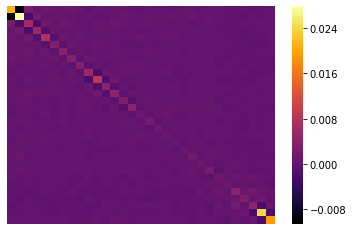

In [45]:
sns.heatmap(pd.DataFrame(new_cov), fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [46]:
fake_data = np.concatenate((ranz.reshape(-1,1), pred_random), axis=1)
np.savetxt("fake_binned_JLA.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu")

In [47]:
errors = np.sqrt(np.abs(np.diagonal(syscov)))
fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))
np.max(errors), np.max(fakeerrors)

(0.1677960745965173, 0.16685422)

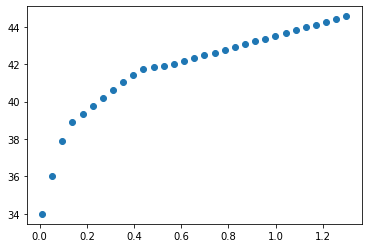

In [48]:
plt.scatter(ranz, pred_random)

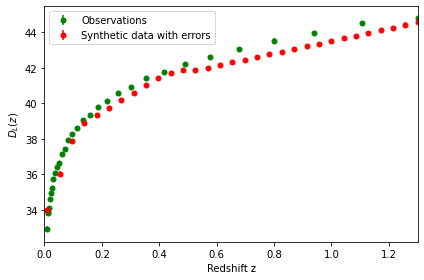

In [49]:
plt.errorbar(z, dl, yerr=errors, fmt='g.', markersize=10, label='Observations')
plt.errorbar(ranz, pred_random, 
             yerr=fakeerrors, fmt='r.', markersize=10., label='Synthetic data with errors')

# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$D_L(z)$")
plt.xlim(0, np.max(z))
plt.tight_layout()
plt.legend()
# plt.savefig('fake_vs_binned_jla.png', dpi=200)

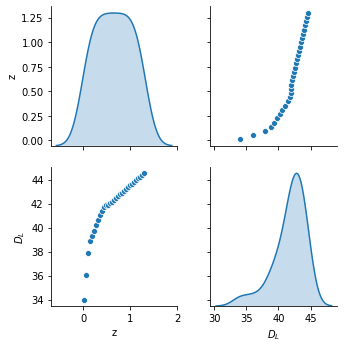

In [50]:
fake_datadf = pd.DataFrame(fake_data, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf, diag_kind="kde")
plt.savefig('fake_binned_jla.png')

### NOW we use dropout as uncertainty estimator

In [51]:
from astroNN.nn.layers import MCDropout

In [52]:
# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img2 = tf.keras.Input(shape=(31*31,))
# begin encoder
x2 = layers.Dense(100, activation='tanh')(input_img2)
x2 = MCDropout(0.2)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.2)(x2)
encoded2 = layers.Dense(encoding_dim, activation='tanh')(x2)
x2 = MCDropout(0.2)(encoded2)
#begin decoder
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.2)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
# x2 = MCDropout(0.2)(x2)
decoded2 = layers.Dense(31*31, activation='linear')(x2)


# This model maps an input to its reconstruction
autoencoder2 = tf.keras.Model(input_img2, decoded2)
autoencoder2.compile(optimizer='adam', loss='mean_squared_error')
autoencoder2.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               96200     
_________________________________________________________________
MCDropout_1 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
MCDropout_2 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 31)                3131      
_________________________________________________________________
MCDropout_3 (MCDropout)      (None, 31)               

In [53]:
batch_size = 4
# optimizer = Adam(lr=.005)
# optimizer = Adam(lr=0.0001)


autoencoder2_train = autoencoder2.fit(covset_noise_train, covset_train,
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(covset_noise_test, covset_test),
                    callbacks=callbacks)

Epoch 1/500
25/25 [==============================] - 0s 6ms/step - loss: 6.3570e-04 - val_loss: 2.2901e-04
Epoch 2/500
25/25 [==============================] - 0s 3ms/step - loss: 1.3559e-04 - val_loss: 1.0244e-04
Epoch 3/500
25/25 [==============================] - 0s 3ms/step - loss: 6.5110e-05 - val_loss: 6.3180e-05
Epoch 4/500
25/25 [==============================] - 0s 3ms/step - loss: 4.2977e-05 - val_loss: 4.6264e-05
Epoch 5/500
25/25 [==============================] - 0s 3ms/step - loss: 3.1504e-05 - val_loss: 3.5249e-05
Epoch 6/500
25/25 [==============================] - 0s 3ms/step - loss: 2.4618e-05 - val_loss: 2.7660e-05
Epoch 7/500
25/25 [==============================] - 0s 3ms/step - loss: 1.9817e-05 - val_loss: 2.4389e-05
Epoch 8/500
25/25 [==============================] - 0s 3ms/step - loss: 1.6320e-05 - val_loss: 2.0470e-05
Epoch 9/500
25/25 [==============================] - 0s 3ms/step - loss: 1.4013e-05 - val_loss: 1.7473e-05
Epoch 10/500
25/25 [=================

Epoch 77/500
25/25 [==============================] - 0s 2ms/step - loss: 1.2838e-06 - val_loss: 1.4167e-06
Epoch 78/500
25/25 [==============================] - 0s 2ms/step - loss: 1.2697e-06 - val_loss: 1.4071e-06
Epoch 79/500
25/25 [==============================] - 0s 2ms/step - loss: 1.2634e-06 - val_loss: 1.4038e-06
Epoch 80/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2524e-06 - val_loss: 1.3834e-06
Epoch 81/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2531e-06 - val_loss: 1.3946e-06
Epoch 82/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2491e-06 - val_loss: 1.3815e-06
Epoch 83/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2354e-06 - val_loss: 1.3665e-06
Epoch 84/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2254e-06 - val_loss: 1.3687e-06
Epoch 85/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2249e-06 - val_loss: 1.3478e-06
Epoch 86/500
25/25 [========

25/25 [==============================] - 0s 3ms/step - loss: 1.0879e-06 - val_loss: 1.1285e-06
Epoch 153/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0902e-06 - val_loss: 1.1181e-06
Epoch 154/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0871e-06 - val_loss: 1.1254e-06
Epoch 155/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0899e-06 - val_loss: 1.1228e-06
Epoch 156/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0847e-06 - val_loss: 1.1192e-06
Epoch 157/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0841e-06 - val_loss: 1.1160e-06
Epoch 158/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0832e-06 - val_loss: 1.1147e-06
Epoch 159/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0853e-06 - val_loss: 1.1164e-06
Epoch 160/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0820e-06 - val_loss: 1.1193e-06
Epoch 161/500
25/25 [============

25/25 [==============================] - 0s 2ms/step - loss: 1.0619e-06 - val_loss: 1.0782e-06
Epoch 228/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0642e-06 - val_loss: 1.0808e-06
Epoch 229/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0626e-06 - val_loss: 1.0697e-06
Epoch 230/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0597e-06 - val_loss: 1.0807e-06
Epoch 231/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0634e-06 - val_loss: 1.0784e-06
Epoch 232/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0600e-06 - val_loss: 1.0789e-06
Epoch 233/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0624e-06 - val_loss: 1.0753e-06
Epoch 234/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0627e-06 - val_loss: 1.0786e-06
Epoch 235/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0610e-06 - val_loss: 1.0740e-06
Epoch 236/500
25/25 [============

25/25 [==============================] - 0s 2ms/step - loss: 1.0585e-06 - val_loss: 1.0679e-06
Epoch 303/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0550e-06 - val_loss: 1.0692e-06
Epoch 304/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0557e-06 - val_loss: 1.0659e-06
Epoch 305/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0538e-06 - val_loss: 1.0699e-06
Epoch 306/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0544e-06 - val_loss: 1.0673e-06
Epoch 307/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0560e-06 - val_loss: 1.0673e-06
Epoch 308/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0538e-06 - val_loss: 1.0738e-06
Epoch 309/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0561e-06 - val_loss: 1.0643e-06
Epoch 310/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0538e-06 - val_loss: 1.0669e-06
Epoch 311/500
25/25 [============

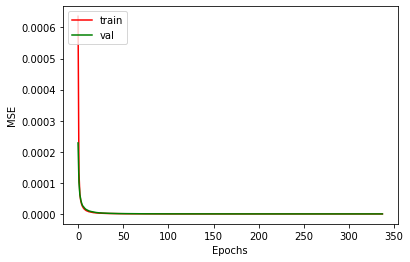

In [54]:
plt.plot(autoencoder2_train.history['loss'], color='r', )
plt.plot(autoencoder2_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLAdropout.png', dpi=200)

In [55]:
encoder2 = tf.keras.Model(input_img2, encoded2)
# This is our encoded (32-dimensional) input
encoded2_input = tf.keras.Input(shape=(encoding_dim,))

decoder2_layer1 = autoencoder2.layers[-5]
decoder2_layer2 = autoencoder2.layers[-4]
decoder2_layer3 = autoencoder2.layers[-3]
decoder2_layer4 = autoencoder2.layers[-2]
decoder2_layer5 = autoencoder2.layers[-1]

# create the decoder model
decoder2 = Model(encoded2_input, 
                decoder2_layer5(decoder2_layer4(decoder2_layer3(decoder2_layer2(decoder2_layer1(encoded2_input))))))

In [56]:
decoder2.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
MCDropout_3 (MCDropout)      (None, 31)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               3200      
_________________________________________________________________
MCDropout_4 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_16 (Dense)             (None, 961)               97061     
Total params: 110,361
Trainable params: 110,361
Non-trainable params: 0
_______________________________________________

In [57]:
# Generate test data
test_batch_size = 31*31
# x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0, 2., test_batch_size)
print(np.shape(fake_encoded))
mc_dropout_num = 100  # Run Dropout 100 times
predictions_dec = np.zeros((mc_dropout_num, 1, test_batch_size))
uncertainty = np.zeros((mc_dropout_num, 1, test_batch_size))
for i in range(mc_dropout_num):
    predictions_dec[i] = decoder2.predict(fake_encoded)
    
# get mean results and its varience
prediction_mc_dropout_dec = np.mean(predictions_dec, axis=0)
std_mc_dropout_dec = np.std(predictions_dec, axis=0)
np.shape(prediction_mc_dropout_dec), np.shape(std_mc_dropout_dec)

(1, 31)


((1, 961), (1, 961))

In [58]:
np.mean(std_mc_dropout_dec), np.shape(std_mc_dropout_dec)

(1.2249738038151204e-05, (1, 961))

In [59]:
def model2_dropout(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = MCDropout(0.02)(efirst)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.02)(x)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.02)(x)
    x = Dense(30, activation='relu')(x)
    x = MCDropout(0.02)(x)
    elast = Dense(1, activation='linear')(x)
    return elast

batch_size = 4
epochs = 400
input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                100       
_________________________________________________________________
MCDropout_5 (MCDropout)      (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                2550      
_________________________________________________________________
MCDropout_6 (MCDropout)      (None, 50)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 50)                2550      
_________________________________________________________________
MCDropout_7 (MCDropout)      (None, 50)              

In [60]:
model2_train = neural_model2.fit(z_train, dl_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, dl_test))

Epoch 1/400
6/6 [==============================] - 0s 18ms/step - loss: 1439.8988 - val_loss: 1736.2838
Epoch 2/400
6/6 [==============================] - 0s 3ms/step - loss: 1430.4708 - val_loss: 1724.7882
Epoch 3/400
6/6 [==============================] - 0s 3ms/step - loss: 1420.5211 - val_loss: 1705.6515
Epoch 4/400
6/6 [==============================] - 0s 3ms/step - loss: 1405.3615 - val_loss: 1682.8429
Epoch 5/400
6/6 [==============================] - 0s 3ms/step - loss: 1379.8647 - val_loss: 1643.4640
Epoch 6/400
6/6 [==============================] - 0s 3ms/step - loss: 1344.4156 - val_loss: 1601.4823
Epoch 7/400
6/6 [==============================] - 0s 4ms/step - loss: 1289.4586 - val_loss: 1513.0271
Epoch 8/400
6/6 [==============================] - 0s 3ms/step - loss: 1206.1244 - val_loss: 1406.8220
Epoch 9/400
6/6 [==============================] - 0s 3ms/step - loss: 1075.6678 - val_loss: 1236.8973
Epoch 10/400
6/6 [==============================] - 0s 4ms/step - loss: 

6/6 [==============================] - 0s 3ms/step - loss: 2.8711 - val_loss: 22.4298
Epoch 83/400
6/6 [==============================] - 0s 3ms/step - loss: 4.4999 - val_loss: 4.8238
Epoch 84/400
6/6 [==============================] - 0s 3ms/step - loss: 7.5748 - val_loss: 5.9775
Epoch 85/400
6/6 [==============================] - 0s 3ms/step - loss: 7.8402 - val_loss: 9.0232
Epoch 86/400
6/6 [==============================] - 0s 3ms/step - loss: 6.9936 - val_loss: 3.6154
Epoch 87/400
6/6 [==============================] - 0s 3ms/step - loss: 6.5153 - val_loss: 3.3811
Epoch 88/400
6/6 [==============================] - 0s 3ms/step - loss: 9.7047 - val_loss: 10.2510
Epoch 89/400
6/6 [==============================] - 0s 3ms/step - loss: 5.2502 - val_loss: 5.6843
Epoch 90/400
6/6 [==============================] - 0s 3ms/step - loss: 6.5235 - val_loss: 8.0977
Epoch 91/400
6/6 [==============================] - 0s 3ms/step - loss: 6.5148 - val_loss: 27.9039
Epoch 92/400
6/6 [============

6/6 [==============================] - 0s 3ms/step - loss: 6.1899 - val_loss: 11.8000
Epoch 165/400
6/6 [==============================] - 0s 3ms/step - loss: 6.0666 - val_loss: 5.1100
Epoch 166/400
6/6 [==============================] - 0s 3ms/step - loss: 7.5274 - val_loss: 5.0945
Epoch 167/400
6/6 [==============================] - 0s 3ms/step - loss: 7.6554 - val_loss: 15.3760
Epoch 168/400
6/6 [==============================] - 0s 3ms/step - loss: 7.4530 - val_loss: 2.7586
Epoch 169/400
6/6 [==============================] - 0s 3ms/step - loss: 3.3078 - val_loss: 4.0964
Epoch 170/400
6/6 [==============================] - 0s 3ms/step - loss: 3.2377 - val_loss: 7.9536
Epoch 171/400
6/6 [==============================] - 0s 3ms/step - loss: 12.4994 - val_loss: 3.2124
Epoch 172/400
6/6 [==============================] - 0s 3ms/step - loss: 5.6148 - val_loss: 7.8558
Epoch 173/400
6/6 [==============================] - 0s 3ms/step - loss: 6.3254 - val_loss: 6.7658
Epoch 174/400
6/6 [==

6/6 [==============================] - 0s 3ms/step - loss: 6.6971 - val_loss: 5.0354
Epoch 247/400
6/6 [==============================] - 0s 3ms/step - loss: 4.9473 - val_loss: 8.6562
Epoch 248/400
6/6 [==============================] - 0s 3ms/step - loss: 5.6518 - val_loss: 3.1204
Epoch 249/400
6/6 [==============================] - 0s 3ms/step - loss: 8.4059 - val_loss: 3.9965
Epoch 250/400
6/6 [==============================] - 0s 3ms/step - loss: 3.7632 - val_loss: 1.1696
Epoch 251/400
6/6 [==============================] - 0s 3ms/step - loss: 6.9879 - val_loss: 1.8899
Epoch 252/400
6/6 [==============================] - 0s 3ms/step - loss: 5.6488 - val_loss: 4.4550
Epoch 253/400
6/6 [==============================] - 0s 4ms/step - loss: 3.6032 - val_loss: 2.8585
Epoch 254/400
6/6 [==============================] - 0s 3ms/step - loss: 5.1684 - val_loss: 5.6153
Epoch 255/400
6/6 [==============================] - 0s 3ms/step - loss: 7.8307 - val_loss: 2.3277
Epoch 256/400
6/6 [=====

6/6 [==============================] - 0s 4ms/step - loss: 5.9401 - val_loss: 3.5428
Epoch 329/400
6/6 [==============================] - 0s 4ms/step - loss: 9.6335 - val_loss: 9.1650
Epoch 330/400
6/6 [==============================] - 0s 3ms/step - loss: 6.5905 - val_loss: 1.1068
Epoch 331/400
6/6 [==============================] - 0s 4ms/step - loss: 6.9320 - val_loss: 4.3918
Epoch 332/400
6/6 [==============================] - 0s 3ms/step - loss: 6.9655 - val_loss: 6.4750
Epoch 333/400
6/6 [==============================] - 0s 3ms/step - loss: 4.4874 - val_loss: 6.6983
Epoch 334/400
6/6 [==============================] - 0s 3ms/step - loss: 9.5004 - val_loss: 4.4677
Epoch 335/400
6/6 [==============================] - 0s 3ms/step - loss: 5.6446 - val_loss: 0.9080
Epoch 336/400
6/6 [==============================] - 0s 3ms/step - loss: 2.2574 - val_loss: 20.3465
Epoch 337/400
6/6 [==============================] - 0s 3ms/step - loss: 3.2906 - val_loss: 9.2491
Epoch 338/400
6/6 [====

In [61]:
# Generate test data
test_batch_size = 31
x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0.01, np.max(z), test_batch_size)

mc_dropout_num = 50  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(scalerz.transform(x_test.reshape(-1,1)))
#     print(predictions[i])

# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

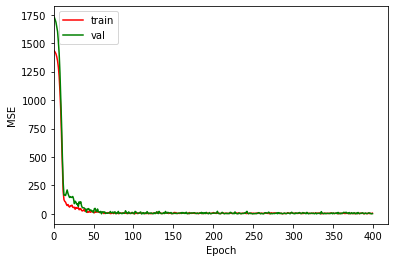

In [62]:
plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_dropoutJLA.png', dpi=100)

In [63]:
np.mean(std_mc_dropout)

2.3580656136888507

In [64]:
Om = 0.27
# variance network
w0 = -1

def RHSquared_a_lcdm(a):
#         return Ezlcdm(a)**2
    return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, model, w0, wa):
        if model == 'lcdm':
            return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
        elif model == 'owacdm':
            return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, model, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(model, w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, model='lcdm', w0=-1, wa=0.5):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, model, w0, wa)*(1+z))+43

In [65]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz))
#     fowacdm1.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.5))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

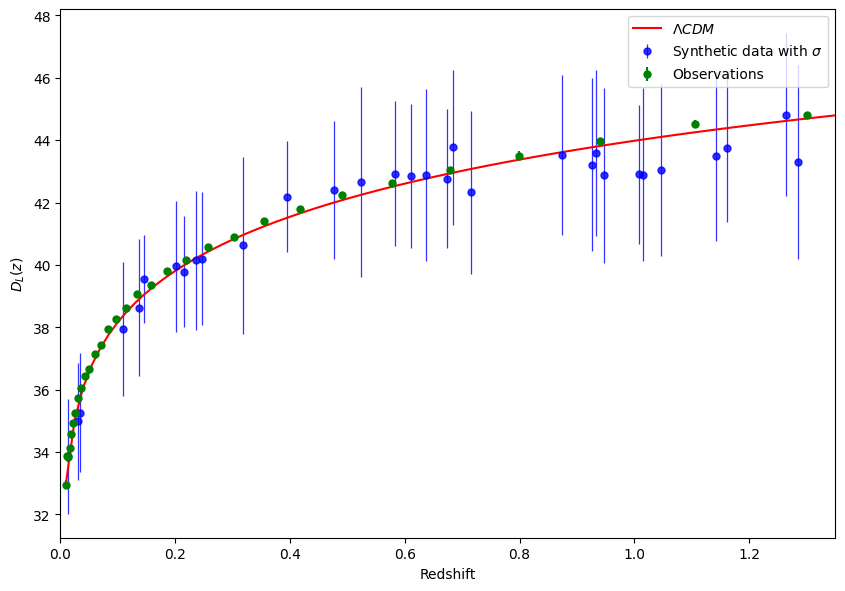

In [66]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)

fakeerrors2 = np.sqrt(np.abs(np.diagonal(prediction_mc_dropout_dec .reshape(31,31))))

std_dropout_diag = np.sqrt(np.abs(np.diagonal(std_mc_dropout_dec.reshape(31,31))))

sigma = np.sqrt(std_mc_dropout.reshape(31,)**2 + fakeerrors2 + std_dropout_diag**2)

plt.errorbar(x_test, prediction_mc_dropout, yerr=sigma
             , markersize=10, fmt='.', 
             ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='b',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='r')
# plt.plot(zmodel, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0, np.max(z)+0.05)
plt.xlabel('Redshift')
plt.ylabel('$D_L(z)$')
# plt.legend(loc='best')
plt.legend(loc='upper right')
# plt.show()
plt.savefig('DL_dropout5.png', dpi=200)

In [67]:
np.savetxt("fake_binned_JLA_COVdecodedDO.dat", prediction_mc_dropout_dec[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
fake_data2 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)
np.savetxt("fake_binned_JLADO.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu")

In [68]:
x_test

array([0.13732897, 0.93314015, 0.03075946, 0.61169532, 0.24616963,
       0.01306443, 1.2646262 , 1.14282892, 1.16122477, 1.04677953,
       0.94764616, 0.68345676, 0.39414085, 1.01583491, 0.92533551,
       0.31879766, 1.28566067, 0.52366889, 0.10982444, 1.0074482 ,
       0.67288364, 0.21501285, 0.63703699, 0.58346821, 0.1459129 ,
       0.03494772, 0.20205808, 0.23663825, 0.87370669, 0.71527107,
       0.47682626])

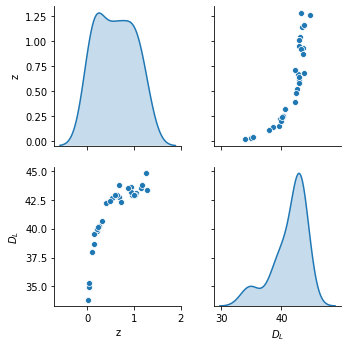

In [69]:
fake_datadf2 = pd.DataFrame(fake_data2, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf2, diag_kind="kde")
plt.savefig('fake_binned_jla22DO.png')

In [70]:
clean_img = autoencoder2.predict(prediction_mc_dropout_dec[0, :].reshape(1,-1))

In [71]:
np.savetxt("fake_binned_JLA_COVdecodedDO.dat", clean_img.reshape(31,31), delimiter= " ", header="#fake COV")
fake_data2 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)
np.savetxt("fake_binned_JLADO.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu")